<a href="https://colab.research.google.com/github/aditya10avg/Image-Generator-GAN-/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [25]:
torch.manual_seed(45)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
transforms=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,),std=(0.5,))]
)

In [27]:
from torchvision.datasets import FashionMNIST
datasets=torchvision.datasets.FashionMNIST(root="data",train=True,download=True,transform=transforms)
dataloader = torch.utils.data.DataLoader(datasets, batch_size=64, shuffle=True)

In [28]:
#Hyper param
latent_dim=100 #size of the random noise vector
hidden_dim=64  #No. of total filters we are going to use.
image_dim=28*28 #size of the image


In [29]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1=nn.Conv2d(1,hidden_dim,kernel_size=4,stride=2,padding=1)
    self.conv2=nn.Conv2d(hidden_dim,hidden_dim*2,kernel_size=4,stride=2,padding=1)
    self.batchnorm2=nn.BatchNorm2d(hidden_dim*2)
    self.conv3=nn.Conv2d(hidden_dim*2 , 1,kernel_size=7,stride=1)

  def forward(self,x):
    out=torch.relu(self.conv1(x))
    out=self.conv2(out)
    out=torch.relu(self.batchnorm2(out))
    out=torch.sigmoid(self.conv3(out))
    out=out.view(out.size(0),-1)
    return out

In [30]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.conv1=nn.ConvTranspose2d(latent_dim,hidden_dim*2,kernel_size=7,stride=1,padding=0)
    self.batch_norm1=nn.BatchNorm2d(hidden_dim*2)
    self.conv2=nn.ConvTranspose2d(hidden_dim*2,hidden_dim,kernel_size=4,stride=2,padding=1)
    self.batch_norm2=nn.BatchNorm2d(hidden_dim)
    self.conv3=nn.ConvTranspose2d(hidden_dim,1,kernel_size=4, stride=2 , padding=1)

  def forward(self,x):
    x=x.view(x.size(0),latent_dim ,1,1)
    out=self.conv1(x)
    out=torch.relu(self.batch_norm1(out))
    out=self.conv2(out)
    out=torch.relu(self.batch_norm2(out))
    out=self.conv3(out)
    out=torch.tanh(out)
    return out

In [31]:
generator=Generator().to(device)
discriminator=Discriminator().to(device)

In [32]:
criterion=nn.BCELoss()
G_optimizer=optim.Adam(generator.parameters(),lr=0.0002)
D_optimizer=optim.Adam(discriminator.parameters(),lr=0.0002)

In [33]:
num_epochs =3
total_steps=len(dataloader)
for epoch in range(num_epochs):
  for i, (real_images,labels) in enumerate(dataloader):
    real_images=real_images.to(device)
    batch_size=real_images.size(0)
    real_labels =torch.ones(batch_size,1).to(device)
    fake_labels=torch.zeros(batch_size,1).to(device)
    real_outputs =discriminator(real_images)
    d_loss_real = criterion(real_outputs,real_labels)
    z=torch.randn(batch_size,latent_dim).to(device)
    fake_images=generator(z)
    fake_outputs=discriminator(fake_images.detach())
    d_loss_fake=criterion(fake_outputs,fake_labels)
    d_loss=d_loss_real +d_loss_fake

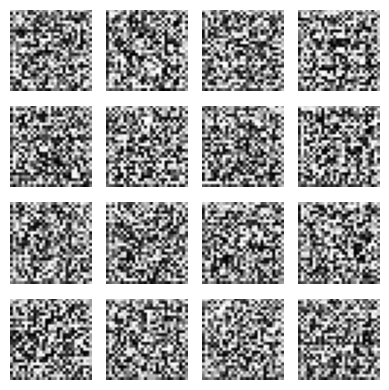

In [34]:
import matplotlib.pyplot as plt
import torchvision.utils

# Generate and plot some fake images
num_samples = 16
z = torch.randn(num_samples, latent_dim).to(device)
fake_images = generator(z).cpu().detach()

plt.figure(figsize=(4, 4))
for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake_images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()